In [1]:
# -------- IMPORTS --------
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from simulation.experiment import ForwardExperiment1D
from utility.distributions import spike, ricker, gaussian, raised_cosine, sinc, homogeneous, exponential, polynomial
from utility.plotting import plot_uv, plot_state, plot_medium, plot_heatmap

In [2]:
# Create experiment
experiment = ForwardExperiment1D(verbose=2)

# Define parameters
nx = 7
parameters_1 = {
    'dx': 1,
    'nx': nx, 
    #'dt': 0.001,
    'dt': 0.05,
    'nt': 200,
    'order': 1,
    'bcs': {'left': 'NBC', 'right': 'DBC'},
    #'mu': homogeneous(3e10, nx+1),
    'mu': homogeneous(3e3, nx+1),
    #'mu': raised_cosine(3e10, nx+1, nx//2, 6, 1e10),
    #'rho': homogeneous(3000, nx),
    'rho': homogeneous(3e3, nx),
    #'rho': raised_cosine(2e3, nx, nx//2, 6, 2e3),
    #'u': ricker(1, nx, nx//2, sigma=20),
    'u': ricker(1, nx, nx//2, sigma=3),
    #'u': homogeneous(1,nx),
    'v': homogeneous(0, nx),
    #'v': homogeneous(1000,nx),
    'backend': {}
    }

# Plot medium
plot_medium(parameters_1['mu'], parameters_1['rho'])

2023-12-01 11:00:30,346 - INFO - Created experiment with time stamp: 20231201T110030.



In [3]:
plot_uv(parameters_1['u'], parameters_1['v'],0, plot_v=True)

In [4]:
experiment.add_solver('ode', **parameters_1)
experiment.add_solver('exp', **parameters_1)
experiment.add_solver('local', **parameters_1)
results = experiment.run()


2023-12-01 11:00:42,528 - INFO - Adding solver 1: ode
2023-12-01 11:00:42,529 - INFO - Parameters checked for validity.
2023-12-01 11:00:42,529 - INFO - Solving for 200 time steps.
2023-12-01 11:00:42,530 - INFO - Calculating Transformation and Hamiltonian.
2023-12-01 11:00:42,533 - INFO - Calculation completed.
2023-12-01 11:00:42,566 - INFO - Medium initialized.
2023-12-01 11:00:42,579 - INFO - Initial state forward-transformed.
2023-12-01 11:00:42,582 - INFO - Solver 0 added.

2023-12-01 11:00:42,586 - INFO - Adding solver 2: exp
2023-12-01 11:00:42,592 - INFO - Parameters checked for validity.
2023-12-01 11:00:42,612 - INFO - Solving for 200 time steps.
2023-12-01 11:00:42,620 - INFO - Calculating Transformation and Hamiltonian.
2023-12-01 11:00:42,627 - INFO - Calculation completed.
2023-12-01 11:00:42,641 - INFO - Medium initialized.
2023-12-01 11:00:42,643 - INFO - Initial state forward-transformed.
2023-12-01 11:00:42,643 - INFO - Solver 1 added.

2023-12-01 11:00:42,645 - INFO

In [5]:
# experiment2 = ForwardExperiment1D(experiment_id='20231130T165254', verbose=2)
# results = experiment2.load()


2023-12-01 09:06:44,703 - INFO - Loading experiment with time stamp: 20231130T165254.

2023-12-01 09:06:44,707 - INFO - Loading data for solver 1.
2023-12-01 09:06:44,717 - INFO - Loading data for solver 2.
2023-12-01 09:06:44,726 - INFO - Data loaded.



In [5]:
l2_errors_1 = np.linalg.norm(results[1]['field']['u'] - results[0]['field']['u'], axis=1) / np.linalg.norm(results[0]['field']['u'], axis=1)
l2_errors_2 = np.linalg.norm(results[2]['field']['u'] - results[0]['field']['u'], axis=1) / np.linalg.norm(results[0]['field']['u'], axis=1)
print(np.mean(l2_errors_1))
print(np.mean(l2_errors_2))

fig = go.Figure()
fig.add_trace(go.Scatter(x=results[0]['times'], y=l2_errors_1, name='math'))
fig.add_trace(go.Scatter(x=results[0]['times'], y=l2_errors_2, name='local'))
fig.update_layout(title='L2 Error', xaxis_title='Time', yaxis_title='Error')
fig.show()

0.0009002296480542796
0.017634394892772562


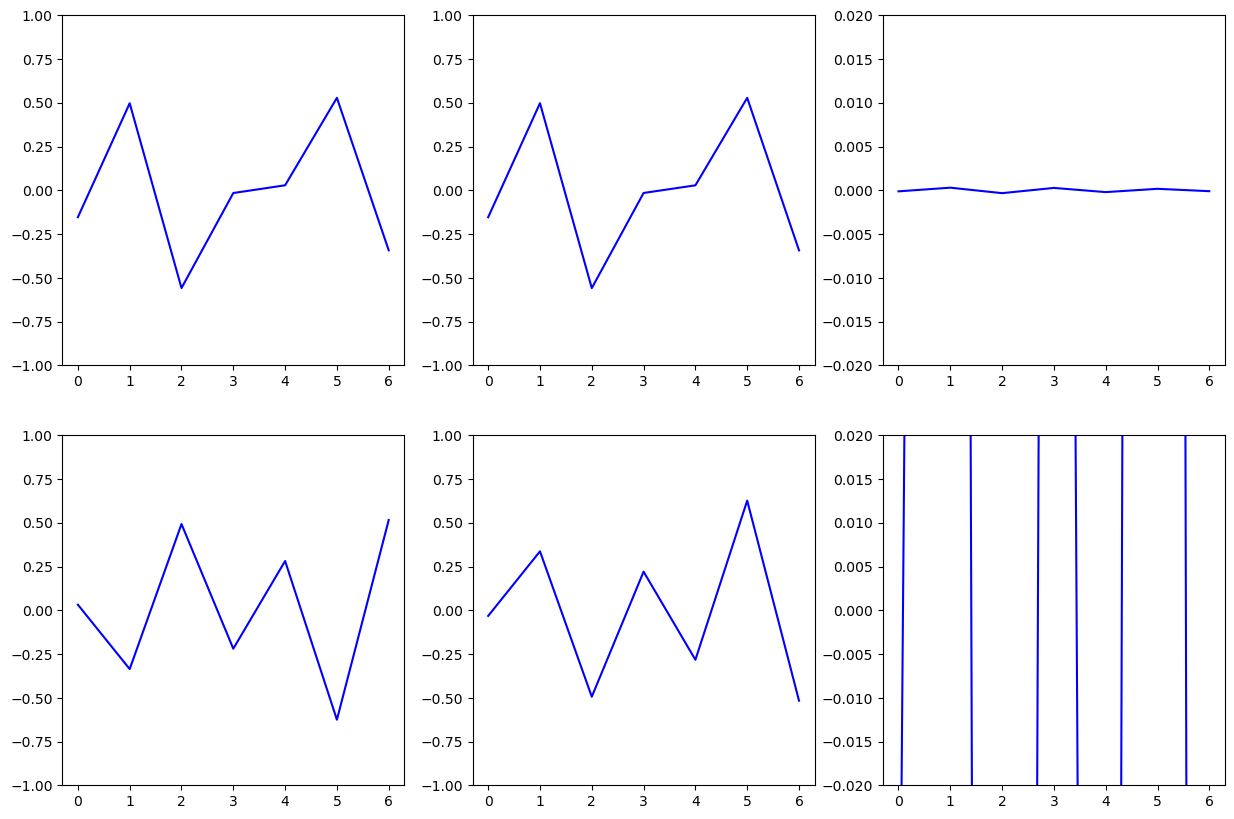

In [6]:
def get_anim(y_values_list, y_axis_list):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    lines = []
    for ax, y_values, y_axis in zip(axs, y_values_list, y_axis_list):
        line, = ax.plot(y_values[0, :], color='blue')
        ax.set_ylim(y_axis)
        lines.append(line)

    def animate(i):
        for line, y_values in zip(lines, y_values_list):
            line.set_ydata(y_values[i, :])
        return lines

    anim = FuncAnimation(fig, animate, frames=len(y_values_list[0]), interval=3000, blit=True)
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Malte Schade'), bitrate=1800)
    anim.save('wave_field.mp4', writer=writer)
    plt.show()

    return anim

y_values1 = results[0]['field']['u']
y_values2 = results[1]['field']['u']
y_values3 = results[1]['field']['u'] - results[0]['field']['u']
y_values4 = results[0]['field']['v']
y_values5 = results[1]['field']['v']
y_values6 = results[1]['field']['v'] - results[0]['field']['v']
y_axis1 = [-1, 1]
y_axis2 = [-1, 1]
y_axis3 = [-0.02, 0.02]
y_axis4 = [-1, 1]
y_axis5 = [-1, 1]
y_axis6 = [-0.02, 0.02]
y_values = [y_values1, y_values2, y_values3, y_values4, y_values5, y_values6]
y_axis = [y_axis1, y_axis2, y_axis3, y_axis4, y_axis5, y_axis6]

get_anim(y_values, y_axis)


In [10]:
idx = 30
u1 = results[0]['field']['u'][idx]
u2 = results[1]['field']['u'][idx]
v1 = results[0]['field']['v'][idx]
v2 = results[1]['field']['v'][idx]
t = results[0]['times'][idx]
plot_uv(u1, v1, t, plot_v=True, range_u=[-10, 10])

In [29]:
plot_uv(u2, v2, t, plot_v=True, range_u=[-10, 10])

In [30]:
plot_uv(u1-u2, v1-v2, t, plot_v=True, range_u=[-0.05, 0.05], range_v=[-50, 50])

In [52]:
# Insights
# Error independent of Amplitude
# Error also for homogeneous / independent of medium
# Error for DBC-DBC -> Sinusoidal pattern for both (but more velocities) (ricker)
# Error for NBC-DBC -> same, smaller for DBC-NBC?
# Error between pos and vel positively correlated 
# Zig-Zag pattern
# Error stays same for high shot number
# Error asymmetric! Even for DBC-DBC / symmetric wavelet / homog. medium

# Homog. initial cond. -> 8 elements for position, 7 elements for velocity, 1 free value=0  (16 elem) (Quantum)
# All vel elements same value, all pos elements=0 apart from first and last (at homog initial)

# Homog. initial cond. -> 7 elements for position, 7 elements for velocity (14 elem) (ODE)

# Error Gets smaller for higher number of gridpoints!

# Guess 1: Numerical implementation error due to very small/very large hamiltonian values
# Guess 2: Error due to zero-fields in state having non-zero values -> Bleeding into wave field
# Guess 3: Leap-frog scheme creates zig-zag error (n vs n+1 position elements)

# Large sim -> symmetrical error for position (sometimes only?)

# Many tim sim for equal rho/mu -> Noise looks very random but: Not easily reducable with shot number